## QDenseBatchnorm Test Notebook
***
QDenseBatchnorm should fold quantized Dense parameters into the the Batchnorm layer to reduce the LUT (look up table) utilization at HLS and Vivado FPGA Implementation time

In [1]:
import common as com
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l1
from qkeras.qlayers import QDense, QActivation
from qkeras import QDenseBatchnorm
from qkeras.quantizers import quantized_bits, quantized_relu
import os
import hls4ml
from plot_roc import plot_roc

os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

/opt/conda/envs/qdense_batchnorm/lib/python3.7/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
def reference_model(bits=12, int_bits=6, relu_bits = 6):

    keras.backend.reset_uids()
    '''
    define the reference quantized model for the autoencoder, with fewer layers
    '''
    inputLayer = Input(shape=(128))
    kwargs = {
        'kernel_quantizer': quantized_bits(bits, int_bits, alpha=1),
        'bias_quantizer': quantized_bits(bits, int_bits, alpha=1),
        'kernel_initializer': 'lecun_uniform',
        'kernel_regularizer': l1(0) 
    }
    
    #declare encoder
    h = QDense(64, **kwargs)(inputLayer)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    h = QDense(64, **kwargs)(h)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #declare latent layer
    h = QDense(8, **kwargs)(h)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #declare decoder
    h = QDense(64, **kwargs)(h)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    h = QDense(64, **kwargs)(h)
    h = BatchNormalization()(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #output layer
    h = QDense(128, **kwargs)(h)
    
    return Model(inputs=inputLayer, outputs=h)


def qdense_batchnorm_model(bits=12, int_bits=6, relu_bits = 6):
    keras.backend.reset_uids()
    '''
    define the densebatchnorm quantized model for the autoencoder, with fewer layers
    '''
    inputLayer = Input(shape=(128))
    kwargs = {
        'kernel_quantizer': quantized_bits(bits, int_bits, alpha=1),
        'bias_quantizer': quantized_bits(bits, int_bits, alpha=1),
        'kernel_initializer': 'lecun_uniform',
        'kernel_regularizer': l1(0) 
    }
    
    #declare encoder
    h = QDenseBatchnorm(64, **kwargs)(inputLayer)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    h = QDenseBatchnorm(64, **kwargs)(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #declare latent layer
    h = QDenseBatchnorm(8, **kwargs)(h)
    h = QActivation(activation=quantized_relu(relu_bits))(h)
    
    #declare decoder
    h = QDenseBatchnorm(64, **kwargs)(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)

    h = QDenseBatchnorm(64, **kwargs)(h)
    h = QActivation(activation=quantized_relu(relu_bits,0))(h)
    
    #output layer
    h = QDense(128, **kwargs)(h)
    
    return Model(inputs=inputLayer, outputs=h)


### Create Train Data using ToyADMOS toy car dataset

In [3]:
param = com.yaml_load('data_gen_config.yml')
param = param["train"]
train_data_save_load_directory = "./train_time_data/train_data_inputs_{}_frames_{}_hops_{}_fft_{}_mels_{}_power_{}_downsample_{}.npy".format(
        param["model"]["input_dim"],param["feature"]["frames"], param["feature"]["hop_length"], 
            param["feature"]["n_fft"], param["feature"]["n_mels"], param["feature"]["power"],param["feature"]["downsample"],)
        
# if train_data available, load processed data in local directory without reprocessing wav files --saves time--
if os.path.exists(train_data_save_load_directory):
    print("Loading train_data from {}".format(train_data_save_load_directory))
    train_data = np.load(train_data_save_load_directory)
else:
    !python generate_train_data.py -c data_gen_config.yml
    train_data = np.load(train_data_save_load_directory)

Loading train_data from ./train_time_data/train_data_inputs_128_frames_5_hops_512_fft_1024_mels_128_power_2.0_downsample_True.npy


### train reference model

In [4]:
if not os.path.exists('./model/ref/reference_model.h5'):
    ref_model = reference_model()
    ref_model.compile(loss='mean_squared_error', optimizer='adam')
    ref_model.summary()
    ref_model.fit(train_data, train_data, batch_size=512, epochs=10, shuffle=1,validation_split=0.1, verbose=1)
    ref_model.save('./model/ref/reference_model.h5')
else:
    ref_model = com.load_model('./model/ref/reference_model.h5')
    ref_model.summary()

2022-01-20 20:50:31.428979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 20:50:31.439257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 20:50:31.440036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 20:50:31.441756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 q_dense (QDense)            (None, 64)                8256      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 q_activation (QActivation)  (None, 64)                0         
                                                                 
 q_dense_1 (QDense)          (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

In [5]:
if not os.path.exists('./model/qdbn/qdbn_model.h5'):
    qdbn_model = qdense_batchnorm_model()
    qdbn_model.compile(loss='mean_squared_error', optimizer='adam')
    qdbn_model.summary()
    qdbn_model.fit(train_data, train_data, batch_size=512, epochs=10, shuffle=1,validation_split=0.1, verbose=1)
    qdbn_model.save('./model/qdbn/qdbn_model.h5')
else:
    qdbn_model = com.load_model('./model/qdbn/qdbn_model.h5')
    qdbn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 q_dense_batchnorm (QDenseBa  (None, 64)               8513      
 tchnorm)                                                        
                                                                 
 q_activation (QActivation)  (None, 64)                0         
                                                                 
 q_dense_batchnorm_1 (QDense  (None, 64)               4417      
 Batchnorm)                                                      
                                                                 
 q_activation_1 (QActivation  (None, 64)               0         
 )                                                               
                                                             

### Load test data

In [6]:
# if train_data available, load processed data in local directory without reprocessing wav files --saves time--
X_npy_dir =  './test_data/anomaly_detection/128input_test_data.npy'
y_npy_dir = './test_data/anomaly_detection/128input_test_data_ground_truths.npy'
X = np.load('./test_data/anomaly_detection/128input_test_data.npy', allow_pickle=1)

### Compare keras performance qdbn_model and ref_model

using 1/1 of provided dataset for roc plot


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/615 [00:00<?, ?it/s]

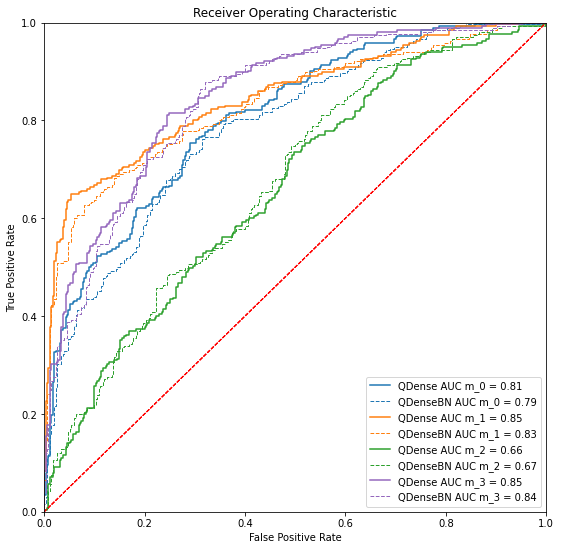

In [7]:
%matplotlib inline
plot_roc(ref_model, qdbn_model, X_npy_dir, y_npy_dir)

### HLS4ML Translation of reference model

In [8]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
#hls_config = com.yaml_load('model/ref/hls4ml_config.yml')
hls_config = hls4ml.utils.config_from_keras_model(ref_model, granularity='name')
hls_config['Model']['ReuseFactor'] = 16384
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['LayerName']['input_1']['Precision'] = 'ap_fixed<8,8>'
for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True
    hls_config['LayerName'][layer]['ResueFactor'] = 16384 #huge number, hls4ml will clip to #inputs*layer_width
    hls_config['LayerName'][layer]['accum_t'] = 'ap_fixed<32,16>'

cfg = hls4ml.converters.create_config(
            backend='Vivado',
            part='xc7z020clg400-1',
            clock_period=10,
            io_type='io_stream')

cfg['HLSConfig'] = hls_config
cfg['InputData'] = 'test_data/anomaly_detection/test_bench/128input_test_data.npy'
cfg['OutputPredictions'] = 'test_data/anomaly_detection/test_bench/128input_test_data.npy'
cfg['KerasModel'] = ref_model
cfg['OutputDir'] = 'hls/ref_prj'

print("-----------------------------------")
com.print_dict(cfg)
print("-----------------------------------")

ref_hls_model = hls4ml.converters.keras_to_hls(cfg)

ref_hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: q_dense, layer type: QDense
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: q_activation, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: q_activation_1, layer type: QActivation
Layer name: q_dense_2, layer type: QDense
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: q_activation_2, layer type: QActivation
Layer name: q_dense_3, layer type: QDense
Layer name: batch_normalization_3, layer type: BatchNormalization
Layer name: q_activation_3, layer type: QActivation
Layer name: q_dense_4, layer type: QDense
Layer name: batch_normalization_4, layer type: BatchNormalization
Layer name: q_activation_4, layer type: QActivation
Layer name: q_dense_5, layer type: QDense
-----------------------------------
OutputDir:           hls/ref_prj
ProjectName:         myproj

Done


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: q_dense, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 64]
BatchNormalization
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 64]
BatchNormalization
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_dense_2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 8]
BatchNormalization
Layer name: batch_normalization_2, layer type: BatchNormalization, input shapes: [

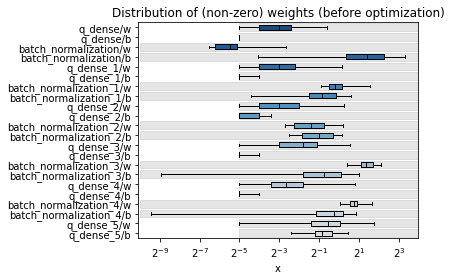

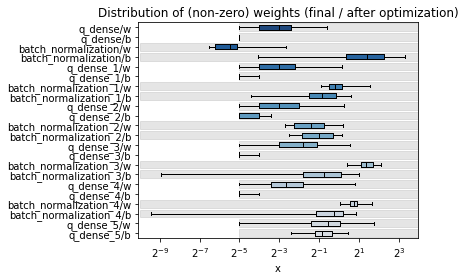

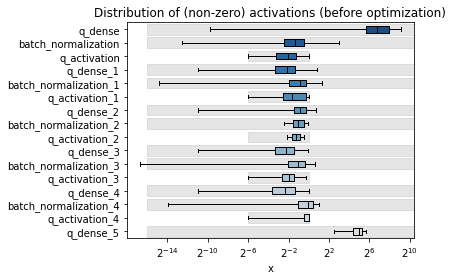

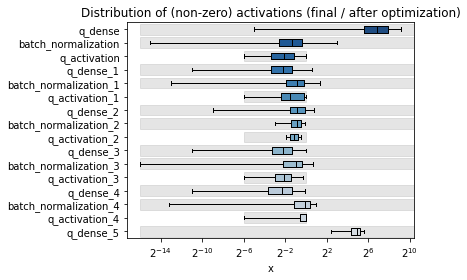

In [9]:
_= hls4ml.model.profiling.numerical(model=ref_model, hls_model=ref_hls_model,X=X[0][0])
# Run tracing on a portion of the test set for the hls model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = ref_hls_model.trace(np.ascontiguousarray(X[0][0][0]))

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(ref_model, X[0][0])


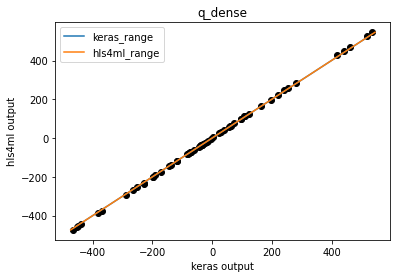

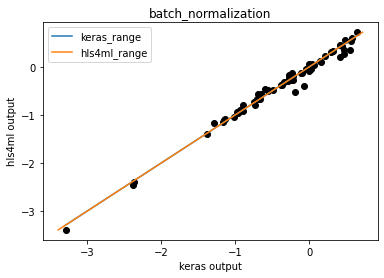

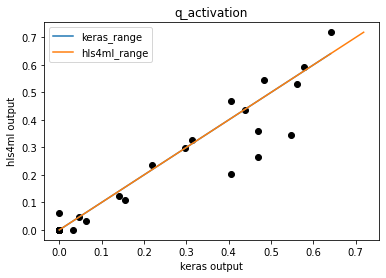

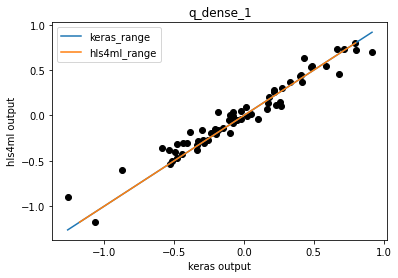

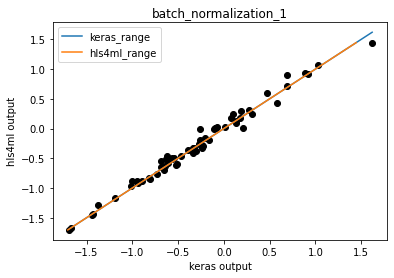

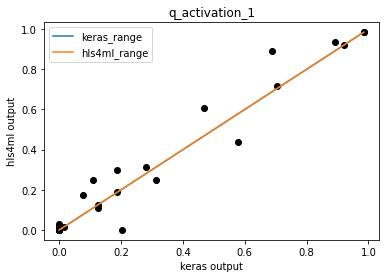

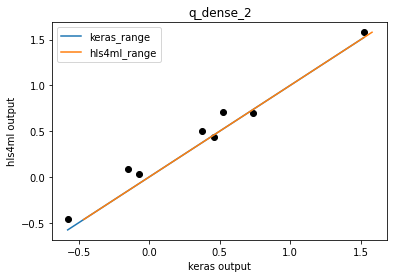

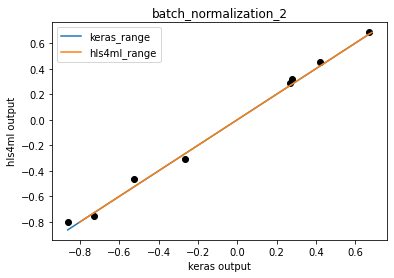

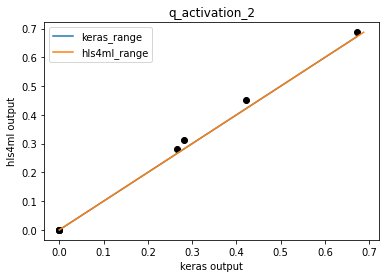

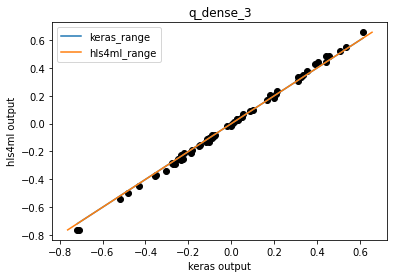

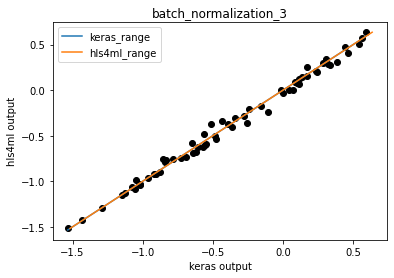

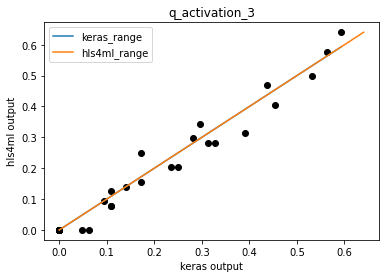

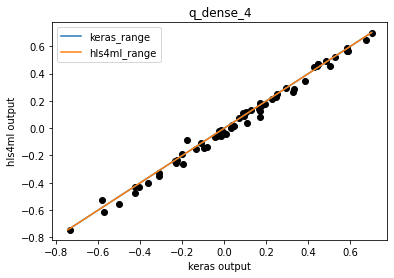

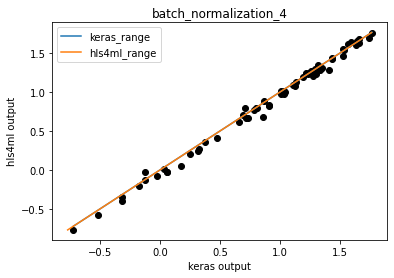

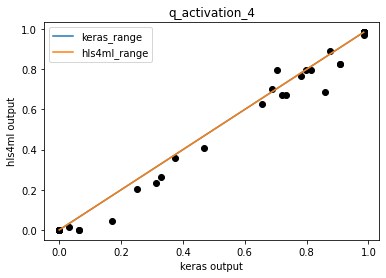

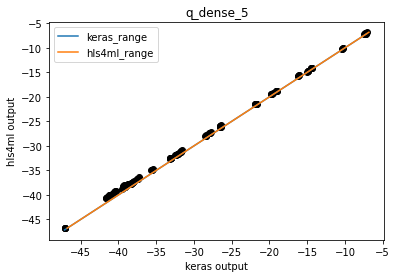

In [10]:
%matplotlib inline
for key in hls4ml_trace:
    plt.figure()
    plt.scatter(keras_trace[key][0], hls4ml_trace[key][0], color='black')
    plt.plot(np.linspace(np.min(keras_trace[key][0]),np.max(keras_trace[key][0]), 10), 
             np.linspace(np.min(keras_trace[key][0]),np.max(keras_trace[key][0]), 10), label='keras_range')
    plt.plot(np.linspace(np.min(hls4ml_trace[key][0]),np.max(hls4ml_trace[key][0]), 10), 
             np.linspace(np.min(hls4ml_trace[key][0]),np.max(hls4ml_trace[key][0]), 10), label='hls4ml_range')
    plt.title(key)
    plt.xlabel('keras output')
    plt.ylabel('hls4ml output')
    plt.legend()
    plt.show()

using 1/4 of provided dataset for roc plot


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

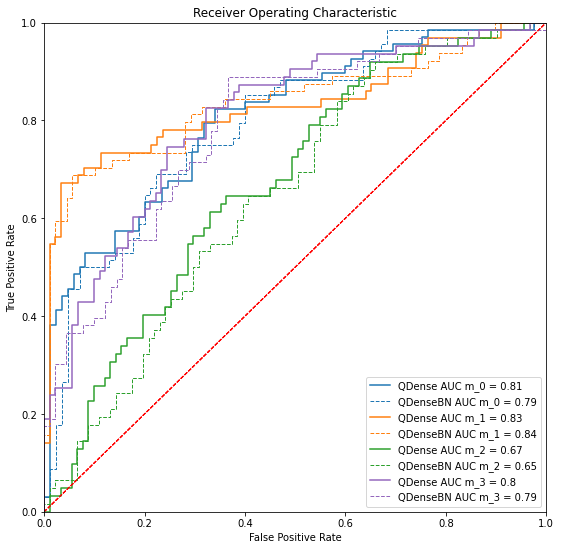

QDense vs QDenseBN plot saved in model/qdbn


<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline
plot_roc(ref_model, ref_hls_model, X_npy_dir, y_npy_dir, data_split_factor=4, output_dir='model/qdbn')

## Convert QDenseBN model

In [12]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
#hls_config = com.yaml_load('model/qdbn/hls4ml_config.yml')
hls_config = hls4ml.utils.config_from_keras_model(qdbn_model, granularity='name')
hls_config['Model']['ReuseFactor'] = 16384
hls_config['Model']['Strategy'] = 'Resource'
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['LayerName']['input_1']['Precision'] = 'ap_fixed<8,8>'
for layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][layer]['Trace'] = True
    hls_config['LayerName'][layer]['ReuseFactor'] = 16384 #large number, hls4ml will clip to #inputs x layer_width
    hls_config['LayerName'][layer]['accum_t'] = 'ap_fixed<32,16>'

cfg = hls4ml.converters.create_config(
            backend='VivadoAccelerator',
            part='xc7z020clg400-1',
            clock_period=10,
            io_type='io_stream')

cfg['HLSConfig'] = hls_config
cfg['InputData'] = 'test_data/anomaly_detection/test_bench/128input_test_data.npy'
cfg['OutputPredictions'] = 'test_data/anomaly_detection/test_bench/128input_test_data.npy'
cfg['KerasModel'] = qdbn_model
cfg['OutputDir'] = 'hls/qdbn_prj'

print("-----------------------------------")
com.print_dict(cfg)
print("-----------------------------------")

qdbn_hls_model = hls4ml.converters.keras_to_hls(cfg)

qdbn_hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: q_dense_batchnorm, layer type: QDenseBatchnorm
Layer name: q_activation, layer type: QActivation
Layer name: q_dense_batchnorm_1, layer type: QDenseBatchnorm
Layer name: q_activation_1, layer type: QActivation
Layer name: q_dense_batchnorm_2, layer type: QDenseBatchnorm
Layer name: q_activation_2, layer type: QActivation
Layer name: q_dense_batchnorm_3, layer type: QDenseBatchnorm
Layer name: q_activation_3, layer type: QActivation
Layer name: q_dense_batchnorm_4, layer type: QDenseBatchnorm
Layer name: q_activation_4, layer type: QActivation
Layer name: q_dense, layer type: QDense
-----------------------------------
OutputDir:           hls/qdbn_prj
ProjectName:         myproject
Backend:             VivadoAccelerator
XilinxPart:          xc7z020clg400-1
Board:               pynq-z2
ClockPeriod:         10
IOType:              io_stream
HLSConfig
  Model
    Precision:       ap_fixed<32,16>
    ReuseFactor

### Profiling QDenseBN model

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128]], output shape: [None, 128]
QDenseBatchnorm
Layer name: q_dense_batchnorm, layer type: QDenseBatchnorm, input shapes: [[None, 128]], output shape: [None, 64]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
QDenseBatchnorm
Layer name: q_dense_batchnorm_1, layer type: QDenseBatchnorm, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
QDenseBatchnorm
Layer name: q_dense_batchnorm_2, layer type: QDenseBatchnorm, input shapes: [[None, 64]], output shape: [None, 8]
Layer name: q_activation_2, layer type: Activation, input shapes: [[None, 8]], output shape: [None, 8]
QDenseBatchnorm
Layer name: q_dense_batchnorm_3, layer type: QDenseBatchnorm, input shapes: [[None, 8]], output shape: [None, 64]
Layer name: q_activation_3, layer type:

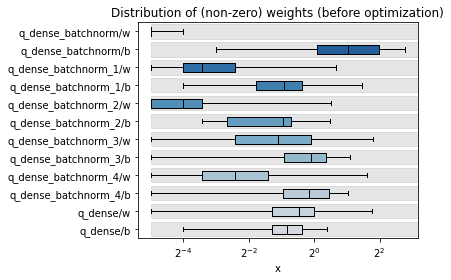

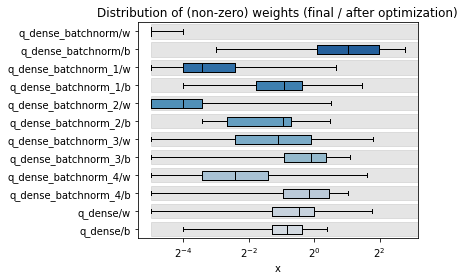

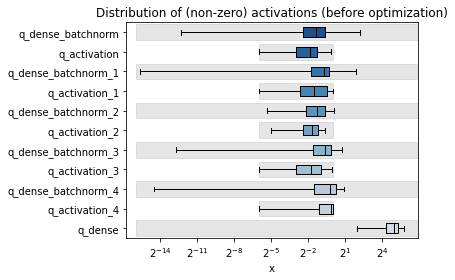

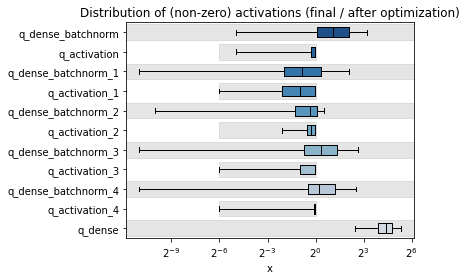

In [13]:
_= hls4ml.model.profiling.numerical(model=qdbn_model, hls_model=qdbn_hls_model,X=X[0][0])
# Run tracing on a portion of the test set for the hls model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = qdbn_hls_model.trace(np.ascontiguousarray(X[0][0][0]))

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(qdbn_model, X[0][0])


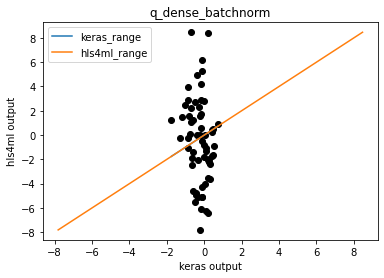

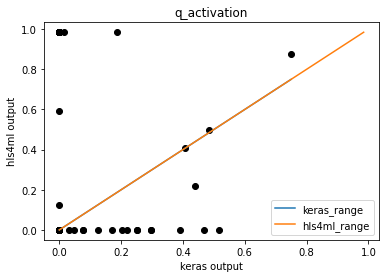

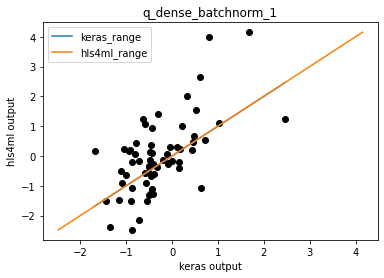

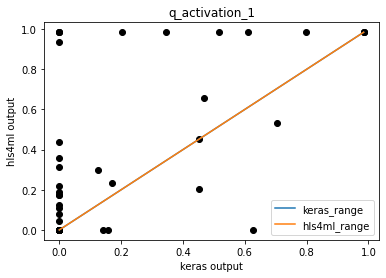

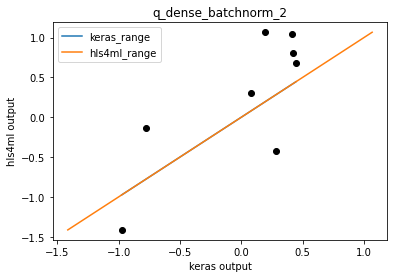

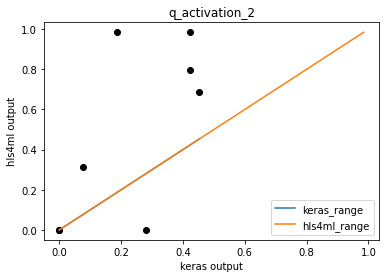

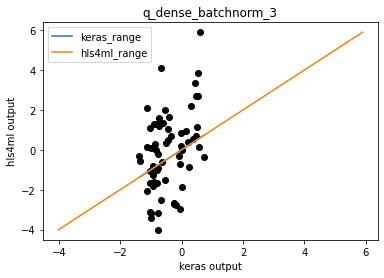

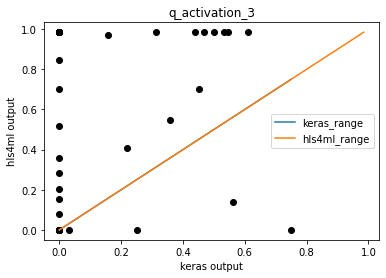

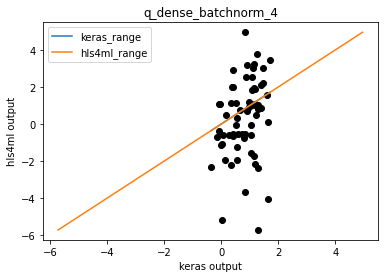

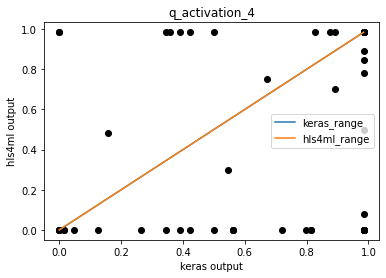

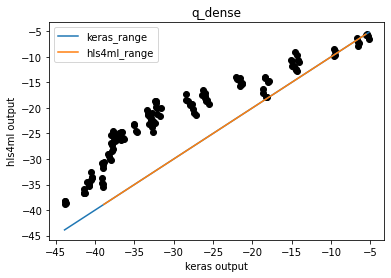

In [14]:
%matplotlib inline
for key in hls4ml_trace:
    plt.figure()
    plt.scatter(keras_trace[key][0], hls4ml_trace[key][0], color='black')
    plt.plot(np.linspace(np.min(keras_trace[key][0]),np.max(keras_trace[key][0]), 10), 
             np.linspace(np.min(keras_trace[key][0]),np.max(keras_trace[key][0]), 10), label='keras_range')
    plt.plot(np.linspace(np.min(hls4ml_trace[key][0]),np.max(hls4ml_trace[key][0]), 10), 
             np.linspace(np.min(hls4ml_trace[key][0]),np.max(hls4ml_trace[key][0]), 10), label='hls4ml_range')
    plt.title(key)
    plt.xlabel('keras output')
    plt.ylabel('hls4ml output')
    plt.legend()
    plt.show()

using 1/4 of provided dataset for roc plot


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

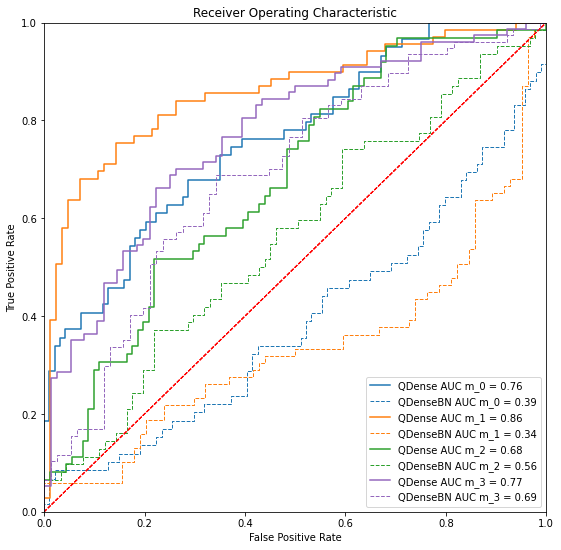

In [15]:
%matplotlib inline
plot_roc(qdbn_model, qdbn_hls_model, X_npy_dir, y_npy_dir, data_split_factor=4)

### Compare performance of HLS (C++) QDenseBN vs QDense->BN